In [45]:
import random
import numpy as np
import matplotlib.pyplot as plt



def decimal_to_binary(array, precision_bits):
    """
    Convert a  NumPy array to a binary string.

    Args:
        - array (numpy.ndarray): an arrays of float or int values.
        - precision_bits (tuple): tuple containing (min_val, max_val, bits) to define the precision for array.
            - min_val (float): The minimum possible value of the original range for the element.
            - max_val (float): The maximum possible value of the original range for the element.
            - bits (int): The number of bits used to represent the element in the binary string.

    Returns:
        - binary_string (str): a binary string representing the array.
    """

    min_val, max_val, bits = precision_bits

    if max_val == min_val:
        
        binary_string = ''.join(
            '0' * bits
            for _ in array
        )
    else:
        binary_string = ''.join(
            f"{int((val - min_val) / (max_val - min_val) * ((1 << bits) - 1)):0{bits}b}"
            if not np.isnan(val) else '0' * bits  
            for val in array
        )

    return binary_string





def extract_based_on_max_index(list1, list2):
    """
    Extract an object from list1 based on the index of the maximum value in list2.

    Args:
        list1 (list): The list from which to extract the object.
        list2 (list): The list used to determine the index of the maximum value.

    Returns:
        object: The object from list1 corresponding to the index of the maximum value in list2.
    """
    max_index = list2.index(max(list2))

    return list1[max_index]




def mutate(chromosome, mutation_rate):

    """
    Mutate a chromosome  based on its mutation rate.

    Args:
        - chromosome (str): a binary strings representing the chromosome,
        - mutation_rate (float): The probability of mutating each bit in chromosome.

    Returns:
        - mutated_chromosome (str): The mutated chromosome

    Example:
        chromosome = '100001110010101010110'
        mutation_rate = 0.1
        mutated_chromosome = mutate(chromosome, mutation_rates)
    """
    mutated_chromosome = ''.join(
        '1' if bit == '0' and random.random() <= mutation_rate else
        '0' if bit == '1' and random.random() <= mutation_rate else
        bit
        for bit in chromosome
    )

    return mutated_chromosome




def crossover(parent1, parent2, crossover_rate, num_crossover_points):
    """
    Perform multi-point crossover between two parents to generate two offspring.

    Args:
        parent1 (str): A binary string representing the first parent.
        parent2 (str): A binary string representing the second parent.
        crossover_rate (float): Probability of performing crossover for the chromosome.
        num_crossover_points (int): An integer representing the crossover points for the chromosome.

    Returns:
        tuple: Two binary strings representing the offspring.
    """
    if random.random() < crossover_rate:
        crossover_points = sorted(random.sample(range(1, len(parent1)), num_crossover_points))
        child1, child2 = "", ""
        start = 0

        for i, point in enumerate(crossover_points + [len(parent1)]):
            if i % 2 == 0:
                child1 += parent1[start:point]
                child2 += parent2[start:point]
            else:
                child1 += parent2[start:point]
                child2 += parent1[start:point]
            start = point

        offspring1, offspring2 = child1, child2
    else:
        offspring1, offspring2 = parent1, parent2

    return offspring1, offspring2



def initialize_population(pop_size, bit_length):

    """
    Initialize a population for a genetic algorithm.

    Args:
        - pop_size (int): The number of individuals in the population.
        - bit_length (int): The length of the binary string representing each individual.

    Returns:
        - population (list): A list of binary strings, each representing an individual in the population.
    """
    population = [
        ''.join(random.choice('01') for _ in range(bit_length)) for _ in range(pop_size)]

    return population




def select_parents_roulette(population, fitness_scores, population_size):
    """
    Select parents for the next generation based on their fitness scores
    using the Fitness Proportionate Selection (Roulette Wheel Selection) method.

    Args:
        population (list of str): The current population of individuals, each represented as a binary string.
        fitness_scores (list of int): The fitness scores of the individuals in the population.
        population_size (int): number of chromosomes in the original population

    Returns:
        selected (list): The selected parents for the next generation.
    """

    total_fitness = np.sum(fitness_scores)

    if total_fitness == 0:
        probabilities = np.ones(len(fitness_scores)) / len(fitness_scores)
    else:
        probabilities = np.array(fitness_scores) / total_fitness

    selected_indices = np.random.choice(len(population), size=population_size, p=probabilities)
    selected = [population[i] for i in selected_indices]

    return selected




def compute_fitness(population, target):
    """
    Compute the fitness value for each individual in the population.

    Args:
        population (list of str): The population of individuals, each represented as a binary string.
        target (str): The target binary string to compare against.

    Returns:
        fitness_values (list of int): A list of fitness values, one for each individual in the population.
    """
    fitness_values = []

    for individual in population:
        fitness = sum(1 for i, j in zip(individual, target) if i == j)
        fitness_values.append(fitness)

    return fitness_values


def genetic_algorithm(population_size, mutation_rate, crossover_rate, num_crossover_points,
                      target, precision_bits, max_generation=1000, fitness_trigger=None):

    """
    Execute a genetic algorithm to optimize a population of binary-encoded chromosomes.

    Args:
        population_size (int): Number of individuals in the population.

        component of the chromosomes. (min_val, max_val, bits)
        max_generation (int): maximum Number of generations to run the algorithm.
        mutation_rate (float): Probability of mutating each bit in each chromosome.
        crossover_rate (float): Probability of performing crossover for each chromosome.
        num_crossover_points (int): number of crossover points in chromosome.
        target (numpy.ndarray): Target array to compare simulation results against.
        precision_bits (tuple): Tuple containing (min_val, max_val, bits) for encoding the target.
            - min_val (float): Minimum possible value of the target range.
            - max_val (float): Maximum possible value of the target range.
            - bits (int): Number of bits used to represent the target values in the binary string.

        fitness_trigger (int or float): fitness threshold to break the algorithm

    Returns:
        population (list): Final population of binary-encoded chromosomes.
    """

    elite_chromosomes = [] 
    best_fitness = [] 

    print(f"{'-' * 40}")
    print("      *** Genetic Algorithm *** ")
    print(f"{'-' * 40}")

    binary_target = decimal_to_binary(array=target, precision_bits=precision_bits)
    population = initialize_population(
        pop_size=population_size,
        bit_length=len(binary_target)
    )


    if fitness_trigger:
        max_fitness = fitness_trigger
    else:
        max_fitness = len(binary_target)

    max_generation_fitness = 0
    generation = 1

    while generation <= max_generation and max_generation_fitness < max_fitness:

        generation_fitness = compute_fitness(
            population=population,
            target=binary_target
        )

        elite_chromosomes.append(extract_based_on_max_index(list1=population, list2=generation_fitness))
        max_generation_fitness = max(generation_fitness)
        best_fitness.append(max_generation_fitness)

        if max_generation_fitness == max_fitness:
            print()
            print("The Algorithm Found The Best Solution (max fitness == max generation fitness)")
            break

        new_population = []
        parents = select_parents_roulette(
            population=population,
            fitness_scores=generation_fitness,
            population_size=population_size
        )

        for _ in range(len(parents) // 2):

            while len(parents) >= 2:
                parent1 = random.choice(parents)
                parents.remove(parent1)

                if len(parents) > 0:
                    parent2 = random.choice(parents)
                    parents.remove(parent2)
                else:
                    parent2 = parent1
                break  

            offspring1, offspring2 = crossover(
                parent1=parent1,
                parent2=parent2,
                crossover_rate=crossover_rate,
                num_crossover_points=num_crossover_points
            )
            new_population.extend([
                mutate(
                    chromosome=offspring1,
                    mutation_rate=mutation_rate
                ),
                mutate(
                    chromosome=offspring2,
                    mutation_rate=mutation_rate
                )
            ])

        print(f"Generation {generation}; Best/Max Fitness: {max_generation_fitness}/{max_fitness}")
        population = new_population
        generation += 1

    average_fitness = sum(best_fitness) / len(best_fitness)

    print(f"{'------------------------------------------'}")
    print(f"      Simulation Complete!")
    print(f"      The best found fitness: {max(best_fitness)}")
    print(f"      Total Generations: {len(best_fitness)}")
    print(f"      Average Fitness: {average_fitness:.2f}")
    print(f"{'------------------------------------------'}")

    return population, elite_chromosomes, best_fitness, generation
    

In [4]:
bfs1 = []
t1 = np.array([2, 4, 5, 1, 5, 7])
ps = list(range(20, 4001, 20))

for i in range(20):
    
    pop1, elite_chr1, bf1 = genetic_algorithm(
        population_size=ps[i], 
        mutation_rate=0.01, 
        crossover_rate=0.85, 
        num_crossover_points=2,
        target=t1, 
        precision_bits=(0, 10, 8), 
        max_generation=1000
    )
    bfs1.append(bf1)    

----------------------------------------
      *** Genetic Algorithm *** 
----------------------------------------
Generation 1; Best/Max Fitness: 31/48
Generation 2; Best/Max Fitness: 31/48
Generation 3; Best/Max Fitness: 31/48
Generation 4; Best/Max Fitness: 32/48
Generation 5; Best/Max Fitness: 32/48
Generation 6; Best/Max Fitness: 30/48
Generation 7; Best/Max Fitness: 31/48
Generation 8; Best/Max Fitness: 32/48
Generation 9; Best/Max Fitness: 34/48
Generation 10; Best/Max Fitness: 30/48
Generation 11; Best/Max Fitness: 32/48
Generation 12; Best/Max Fitness: 32/48
Generation 13; Best/Max Fitness: 32/48
Generation 14; Best/Max Fitness: 32/48
Generation 15; Best/Max Fitness: 30/48
Generation 16; Best/Max Fitness: 32/48
Generation 17; Best/Max Fitness: 33/48
Generation 18; Best/Max Fitness: 34/48
Generation 19; Best/Max Fitness: 33/48
Generation 20; Best/Max Fitness: 35/48
Generation 21; Best/Max Fitness: 33/48
Generation 22; Best/Max Fitness: 33/48
Generation 23; Best/Max Fitness: 32/

In [14]:
ind1 = list(range(0, 1000, 10)) + [999]
extracted_data = [[inner_list[i] for i in ind1] for inner_list in bfs1[:-1]]

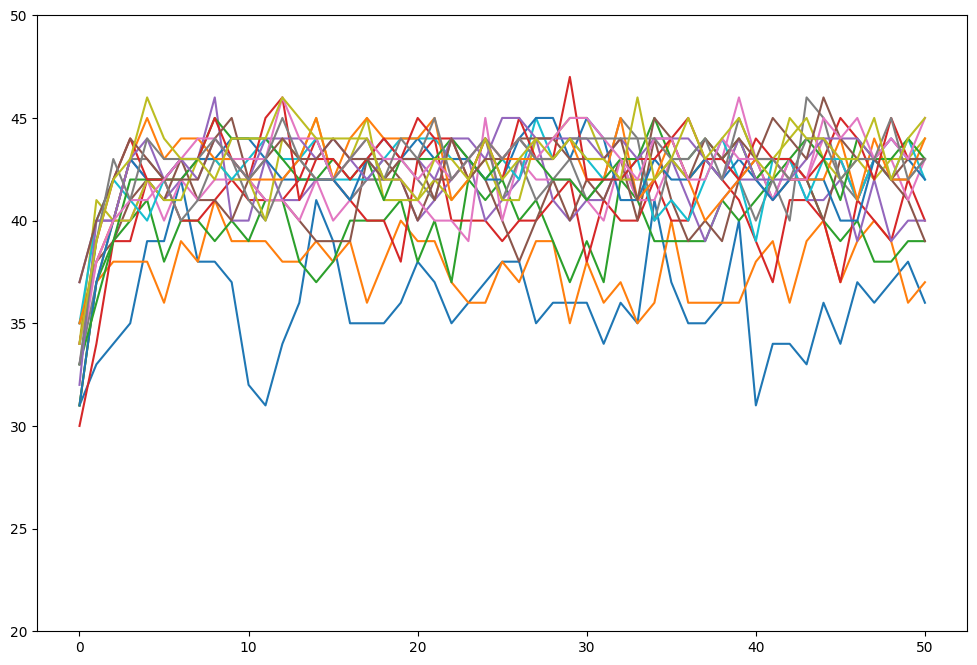

In [25]:
plt.figure(figsize=(12, 8))

for i in range(len(extracted_data)):
    
    plt.plot(extracted_data[i], label=f"pop-size: {ps[i]}")
plt.ylim(20, 50)
#plt.legend()
plt.show()
    

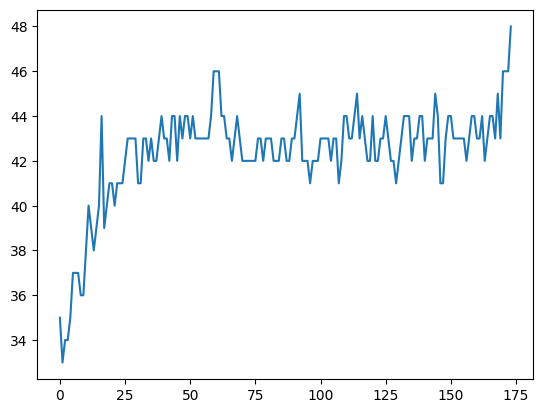

In [26]:
plt.plot(bfs1[-1])
plt.show()

In [42]:
bfs1 = []
t1 = np.array([2, 4, 5, 2, 1])
pb = [(0, 10, 2), (0, 10, 3), (0, 10, 4), (0, 10, 5), (0, 10, 6), (0, 10, 7), (0, 10, 8), (0, 10, 9), (0, 10, 10)]
   
ps = list(range(20, 4001, 20))
gs = []

for i in range(9):
    
    pop1, elite_chr1, bf1, g = genetic_algorithm(
        population_size=200, 
        mutation_rate=0.01, 
        crossover_rate=0.85, 
        num_crossover_points=2,
        target=t1, 
        precision_bits=pb[i], 
        max_generation=10000
    )
    bfs1.append(bf1)
    gs.append(g)

----------------------------------------
      *** Genetic Algorithm *** 
----------------------------------------
Generation 1; Best/Max Fitness: 9/10
Generation 2; Best/Max Fitness: 9/10
Generation 3; Best/Max Fitness: 9/10

The Algorithm Found The Best Solution (max fitness == max generation fitness)
------------------------------------------
      Simulation Complete!
      The best found fitness: 10
      Total Generations: 4
      Average Fitness: 9.25
------------------------------------------
----------------------------------------
      *** Genetic Algorithm *** 
----------------------------------------
Generation 1; Best/Max Fitness: 13/15
Generation 2; Best/Max Fitness: 12/15
Generation 3; Best/Max Fitness: 13/15
Generation 4; Best/Max Fitness: 13/15
Generation 5; Best/Max Fitness: 14/15
Generation 6; Best/Max Fitness: 13/15
Generation 7; Best/Max Fitness: 14/15
Generation 8; Best/Max Fitness: 14/15

The Algorithm Found The Best Solution (max fitness == max generation fitne

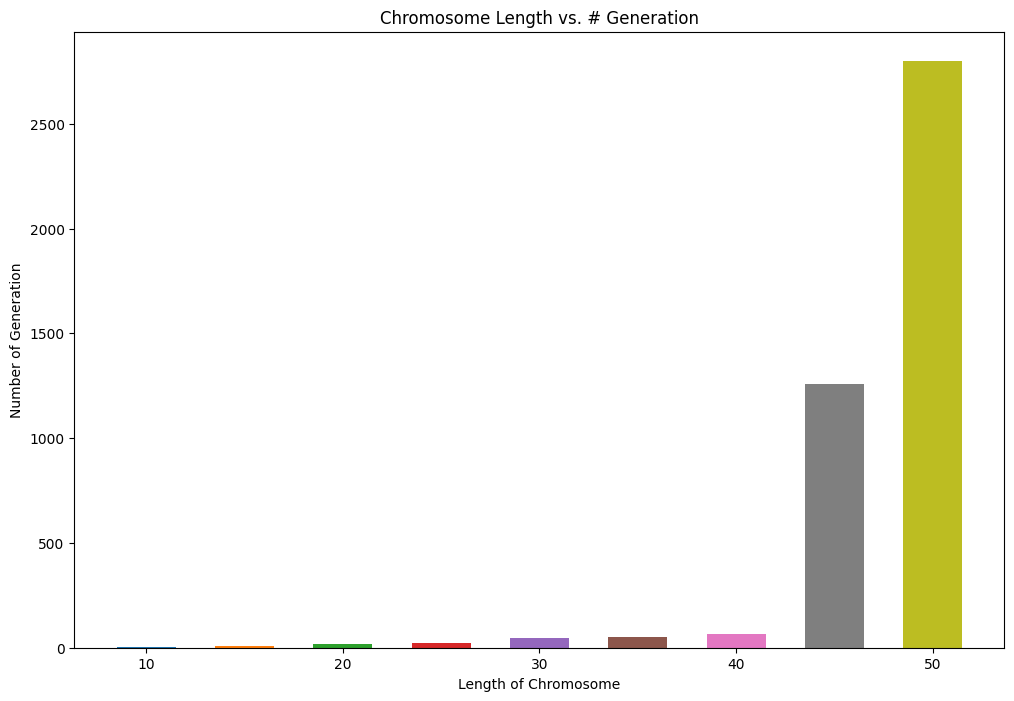

In [43]:
x = [1, 3, 5, 7, 9, 11, 13, 15, 17]
y = [10, 15, 20, 25, 30, 35, 40, 45, 50]
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.bar(y[i], gs[i], width=3)
plt.xlabel("Length of Chromosome")
plt.ylabel("Number of Generation")
plt.title("Chromosome Length vs. # Generation")
plt.show()

In [46]:
bfs1 = []
t1 = np.array([2, 4])
pb = [(0, 10, 10), (0, 10, 11), (0, 10, 12), (0, 10, 13), (0, 10, 14), (0, 10, 15), (0, 10, 16), (0, 10, 17), (0, 10, 18), (0, 10, 19),
     (0, 10, 20), (0, 10, 21), (0, 10, 22), (0, 10, 23), (0, 10, 24), (0, 10, 25), (0, 10, 26), (0, 10, 27), (0, 10, 28), (0, 10, 29),(0, 10, 30)]
   
ps = list(range(20, 4001, 20))
gs = []

for i in range(21):
    
    pop1, elite_chr1, bf1, g = genetic_algorithm(
        population_size=200, 
        mutation_rate=0.01, 
        crossover_rate=0.85, 
        num_crossover_points=2,
        target=t1, 
        precision_bits=pb[i], 
        max_generation=2000
    )
    bfs1.append(bf1)
    gs.append(g)

----------------------------------------
      *** Genetic Algorithm *** 
----------------------------------------
Generation 1; Best/Max Fitness: 15/20
Generation 2; Best/Max Fitness: 17/20
Generation 3; Best/Max Fitness: 16/20
Generation 4; Best/Max Fitness: 18/20
Generation 5; Best/Max Fitness: 18/20
Generation 6; Best/Max Fitness: 18/20
Generation 7; Best/Max Fitness: 18/20
Generation 8; Best/Max Fitness: 18/20
Generation 9; Best/Max Fitness: 18/20
Generation 10; Best/Max Fitness: 18/20
Generation 11; Best/Max Fitness: 18/20
Generation 12; Best/Max Fitness: 18/20
Generation 13; Best/Max Fitness: 19/20
Generation 14; Best/Max Fitness: 18/20
Generation 15; Best/Max Fitness: 19/20
Generation 16; Best/Max Fitness: 19/20
Generation 17; Best/Max Fitness: 19/20
Generation 18; Best/Max Fitness: 19/20
Generation 19; Best/Max Fitness: 19/20

The Algorithm Found The Best Solution (max fitness == max generation fitness)
------------------------------------------
      Simulation Complete!
    

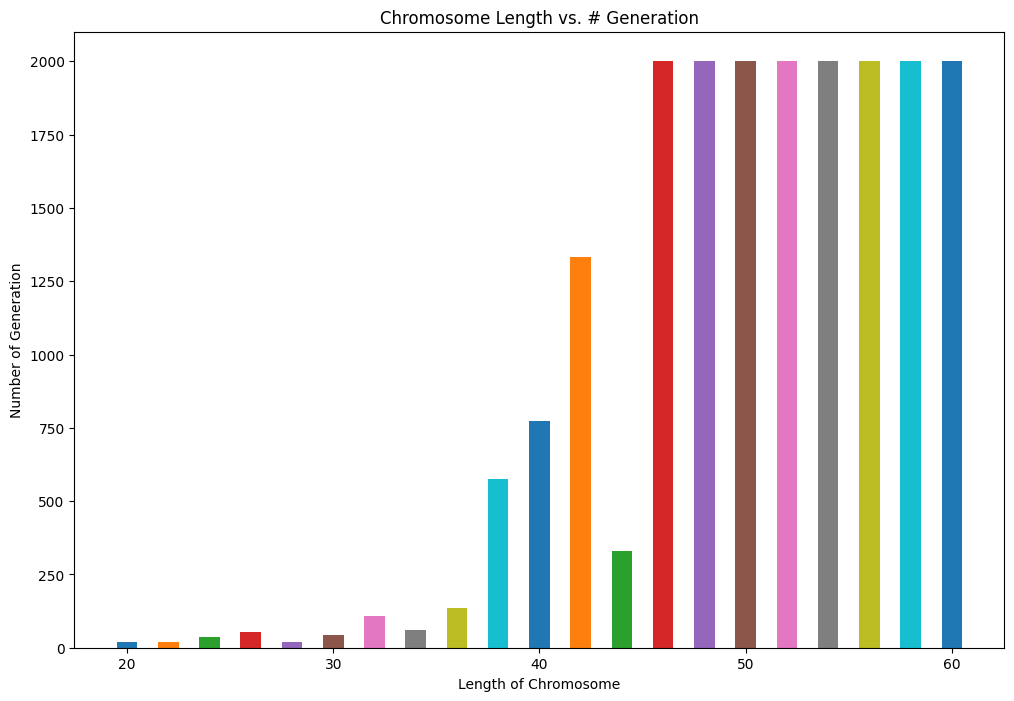

In [50]:
y = list(range(20, 61, 2))
plt.figure(figsize=(12, 8))
for i in range(21):
    plt.bar(y[i], gs[i], width=1)
plt.xlabel("Length of Chromosome")
plt.ylabel("Number of Generation")
plt.title("Chromosome Length vs. # Generation")
plt.show()

[20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60]